## Introduction

Testing an implementation of machine learning using a Sagemaker notebook.  Notebook is a combination of forked example notebooks from AWS.  <br> <br>

Notebook I: https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/1P_kmeans_highlevel/kmeans_mnist.ipynb
<br><br>
Notebook II: https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/mxnet_mnist/mxnet_mnist.ipynb

## Part I:

### Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are two parts to this:

1. The role(s) used to give learning and hosting access to your data. Here we extract the role you created earlier for accessing your notebook.  See the documentation if you want to specify  a different role
1. The S3 bucket name and locations that you want to use for training and model data.

In [1]:
from sagemaker import get_execution_role
role = get_execution_role()
bucket='sgus-machinelearning'

### Data ingestion

Next, we read the dataset from the existing repository into memory, for preprocessing prior to training.  In this case we'll use the MNIST dataset, which contains 70K 28 x 28 pixel images of handwritten digits.  For more details, please see [here](http://yann.lecun.com/exdb/mnist/).

This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 880 ms, sys: 316 ms, total: 1.2 s
Wall time: 1.81 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

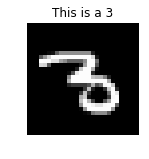

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

## Part II: MXNet

resource: https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/mxnet_mnist/mxnet_mnist.ipynb

In [4]:
from sagemaker import get_execution_role

#Bucket location to save your custom code in tar.gz format.
custom_code_upload_location = 's3://sgus-machinelearning/mxnet/code_output'

#Bucket location where results of model training are saved.
model_artifacts_location = 's3://sgus-machinelearning/mxnet/model_result'

#IAM execution role that gives SageMaker access to resources in your AWS account.
#We can use the SageMaker Python SDK to get the role from our notebook environment. 
role = get_execution_role()

In [15]:
!cat mnist.py

import logging

import gzip
import mxnet as mx
import numpy as np
import os
import struct


def load_data(path):
    with gzip.open(find_file(path, "labels.gz")) as flbl:
        struct.unpack(">II", flbl.read(8))
        labels = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(find_file(path, "images.gz")) as fimg:
        _, _, rows, cols = struct.unpack(">IIII", fimg.read(16))
        images = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(labels), rows, cols)
        images = images.reshape(images.shape[0], 1, 28, 28).astype(np.float32) / 255
    return labels, images


def find_file(root_path, file_name):
    for root, dirs, files in os.walk(root_path):
        if file_name in files:
            return os.path.join(root, file_name)


def build_graph():
    data = mx.sym.var('data')
    data = mx.sym.flatten(data=data)
    fc1 = mx.sym.FullyConnected(data=data, num_hidden=128)
    act1 = mx.sym.Activation(data=fc1, act_type="relu")
    fc2 = mx.sym.FullyConnect

In [6]:
from sagemaker.mxnet import MXNet

mnist_estimator = MXNet(entry_point='mnist.py',
                        role=role,
                        output_path=model_artifacts_location,
                        code_location=custom_code_upload_location,
                        train_instance_count=1, 
                        train_instance_type='ml.m4.xlarge',
                        hyperparameters={'learning_rate': 0.1})

In [7]:
%%time
import boto3

region = boto3.Session().region_name
train_data_location = 's3://sagemaker-sample-data-{}/mxnet/mnist/train'.format(region)
test_data_location = 's3://sagemaker-sample-data-{}/mxnet/mnist/test'.format(region)

mnist_estimator.fit({'train': train_data_location, 'test': test_data_location})

INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-py2-cpu-2018-03-10-04-10-02-529


.................................................................................
executing startup script (first run)
2018-03-10 04:16:05,331 INFO - root - running container entrypoint
2018-03-10 04:16:05,332 INFO - root - starting train task
2018-03-10 04:16:07,174 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 0, 'channels': {u'test': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}, u'train': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'mnist.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model

===== Job Complete =====
CPU times: user 532 ms, sys: 52 ms, total: 584 ms
Wall time: 8min 8s


In [9]:
%%time

predictor = mnist_estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-py2-cpu-2018-03-10-04-10-02-529
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-py2-cpu-2018-03-10-04-10-02-529


---------------------------------------------------------------------------------------!CPU times: user 372 ms, sys: 28 ms, total: 400 ms
Wall time: 7min 31s


### Applying the model

In [11]:
from IPython.display import HTML

In [17]:
HTML(open("input.html").read())

In [24]:
response = predictor.predict(data)
print('Raw prediction result:')
print(response)

labeled_predictions = list(zip(range(10), response[0]))
print('Labeled predictions: ')
print(labeled_predictions)

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print('Most likely answer: {}'.format(labeled_predictions[0]))

Raw prediction result:
[[2.9844851590077326e-10, 0.00033777073258534074, 0.06801191717386246, 0.02219466306269169, 3.923460223376196e-09, 5.201208352900721e-10, 2.4499006339231966e-13, 0.9067538380622864, 0.0026383937802165747, 6.348261376842856e-05]]
Labeled predictions: 
[(0, 2.9844851590077326e-10), (1, 0.00033777073258534074), (2, 0.06801191717386246), (3, 0.02219466306269169), (4, 3.923460223376196e-09), (5, 5.201208352900721e-10), (6, 2.4499006339231966e-13), (7, 0.9067538380622864), (8, 0.0026383937802165747), (9, 6.348261376842856e-05)]
Most likely answer: (7, 0.9067538380622864)


### Example output - Accurately identified "7"

![Chart Image](https://user-images.githubusercontent.com/30188729/37247804-1e1cf834-2476-11e8-99ec-6b44951ae1cb.png)